In [1]:
embedding_deployment = "text-embedding-ada-002"
chat_deployment = "gpt-4o"

# Graph RAG: Graph-Enhanced Retrieval-Augmented Generation

In this notebook, I implement Graph RAG - a technique that enhances traditional RAG systems by organizing knowledge as a connected graph rather than a flat collection of documents. This allows the system to navigate related concepts and retrieve more contextually relevant information than standard vector similarity approaches.

Key Benefits of Graph RAG

- Preserves relationships between pieces of information
- Enables traversal through connected concepts to find relevant context
- Improves handling of complex, multi-part queries
- Provides better explainability through visualized knowledge paths

## Setting Up the Environment
We begin by importing necessary libraries.

In [2]:
import os
import numpy as np
import json
import fitz  # PyMuPDF
from openai import AzureOpenAI
from typing import List, Dict, Tuple, Any
import networkx as nx
import matplotlib.pyplot as plt
import heapq
from collections import defaultdict
import re
from PIL import Image
import io
from dotenv import load_dotenv
# Load environment variables from .env file
load_dotenv()

True

## Setting Up the OpenAI API Client
We initialize the OpenAI client to generate embeddings and responses.

In [3]:
# Initialize the Azure OpenAI client with the endpoint and API key
endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
api_version = os.getenv("API_VERSION")

client = AzureOpenAI(
    api_version=api_version,
    azure_endpoint=endpoint,
    api_key=os.getenv("AZURE_OPENAI_API_KEY")
)

## Document Processing Functions

In [4]:
def extract_text_from_pdf(pdf_path):
    """
    Extract text content from a PDF file.
    
    Args:
        pdf_path (str): Path to the PDF file
        
    Returns:
        str: Extracted text content
    """
    print(f"Extracting text from {pdf_path}...")  # Print the path of the PDF being processed
    pdf_document = fitz.open(pdf_path)  # Open the PDF file using PyMuPDF
    text = ""  # Initialize an empty string to store the extracted text
    
    # Iterate through each page in the PDF
    for page_num in range(pdf_document.page_count):
        page = pdf_document[page_num]  # Get the page object
        text += page.get_text()  # Extract text from the page and append to the text string
    
    return text  # Return the extracted text content

In [5]:
def chunk_text(text, chunk_size=1000, overlap=200):
    """
    Split text into overlapping chunks.
    
    Args:
        text (str): Input text to chunk
        chunk_size (int): Size of each chunk in characters
        overlap (int): Overlap between chunks in characters
        
    Returns:
        List[Dict]: List of chunks with metadata
    """
    chunks = []  # Initialize an empty list to store the chunks
    
    # Iterate over the text with a step size of (chunk_size - overlap)
    for i in range(0, len(text), chunk_size - overlap):
        # Extract a chunk of text from the current position
        chunk_text = text[i:i + chunk_size]
        
        # Ensure we don't add empty chunks
        if chunk_text:
            # Append the chunk with its metadata to the list
            chunks.append({
                "text": chunk_text,  # The chunk of text
                "index": len(chunks),  # The index of the chunk
                "start_pos": i,  # The starting position of the chunk in the original text
                "end_pos": i + len(chunk_text)  # The ending position of the chunk in the original text
            })
    
    # Print the number of chunks created
    print(f"Created {len(chunks)} text chunks")
    
    return chunks  # Return the list of chunks

## Creating Embeddings

In [6]:
def create_embeddings(texts):
    """
    Create embeddings for the given texts using Azure OpenAI's embedding model.
    
    Args:
        texts (List[str] or str): Input texts or single text
        
    Returns:
        List[List[float]] or List[float]: Embedding vectors
    """
    # Handle single string input
    if isinstance(texts, str):
        response = client.embeddings.create(
            model=embedding_deployment,
            input=texts
        )
        return response.data[0].embedding
    
    # Handle empty input
    if not texts:
        return []
        
    # Process in batches if needed (Azure OpenAI API limits)
    batch_size = 100
    all_embeddings = []
    
    # Iterate over the input texts in batches
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]  # Get the current batch of texts
        
        # Create embeddings for the current batch
        response = client.embeddings.create(
            model=embedding_deployment,
            input=batch
        )
        
        # Extract embeddings from the response
        batch_embeddings = [item.embedding for item in response.data]
        all_embeddings.extend(batch_embeddings)  # Add the batch embeddings to the list
    
    return all_embeddings  # Return all embeddings

## Knowledge Graph Construction

In [7]:
def extract_concepts(text):
    """
    Extract key concepts from text using Azure OpenAI's API.
    
    Args:
        text (str): Text to extract concepts from
        
    Returns:
        List[str]: List of concepts
    """
    # System message to instruct the model on what to do
    system_message = """Extract key concepts and entities from the provided text.
Return ONLY a list of 5-10 key terms, entities, or concepts that are most important in this text.
Format your response as a JSON array of strings."""

    # Make a request to the Azure OpenAI API
    response = client.chat.completions.create(
        model=chat_deployment,
        messages=[
            {"role": "system", "content": system_message},
            {"role": "user", "content": f"Extract key concepts from:\n\n{text[:3000]}"}  # Limit for API
        ],
        temperature=0.0,
        response_format={"type": "json_object"}
    )
    
    try:
        # Parse concepts from the response
        concepts_json = json.loads(response.choices[0].message.content)
        concepts = concepts_json.get("concepts", [])
        if not concepts and "concepts" not in concepts_json:
            # Try to get any array in the response
            for key, value in concepts_json.items():
                if isinstance(value, list):
                    concepts = value
                    break
        return concepts
    except (json.JSONDecodeError, AttributeError):
        # Fallback if JSON parsing fails
        content = response.choices[0].message.content
        # Try to extract anything that looks like a list
        matches = re.findall(r'\[(.*?)\]', content, re.DOTALL)
        if matches:
            items = re.findall(r'"([^"]*)"', matches[0])
            return items
        return []

In [8]:
def build_knowledge_graph(chunks):
    """
    Build a knowledge graph from text chunks.
    
    Args:
        chunks (List[Dict]): List of text chunks with metadata
        
    Returns:
        Tuple[nx.Graph, List[np.ndarray]]: The knowledge graph and chunk embeddings
    """
    print("Building knowledge graph...")
    
    # Create a graph
    graph = nx.Graph()
    
    # Extract chunk texts
    texts = [chunk["text"] for chunk in chunks]
    
    # Create embeddings for all chunks
    print("Creating embeddings for chunks...")
    embeddings = create_embeddings(texts)
    
    # Add nodes to the graph
    print("Adding nodes to the graph...")
    for i, chunk in enumerate(chunks):
        # Extract concepts from the chunk
        print(f"Extracting concepts for chunk {i+1}/{len(chunks)}...")
        concepts = extract_concepts(chunk["text"])
        
        # Add node with attributes
        graph.add_node(i, 
                      text=chunk["text"], 
                      concepts=concepts,
                      embedding=embeddings[i])
    
    # Connect nodes based on shared concepts
    print("Creating edges between nodes...")
    for i in range(len(chunks)):
        node_concepts = set(graph.nodes[i]["concepts"])
        
        for j in range(i + 1, len(chunks)):
            # Calculate concept overlap
            other_concepts = set(graph.nodes[j]["concepts"])
            shared_concepts = node_concepts.intersection(other_concepts)
            
            # If they share concepts, add an edge
            if shared_concepts:
                # Calculate semantic similarity using embeddings
                similarity = np.dot(embeddings[i], embeddings[j]) / (np.linalg.norm(embeddings[i]) * np.linalg.norm(embeddings[j]))
                
                # Calculate edge weight based on concept overlap and semantic similarity
                concept_score = len(shared_concepts) / min(len(node_concepts), len(other_concepts))
                edge_weight = 0.7 * similarity + 0.3 * concept_score
                
                # Only add edges with significant relationship
                if edge_weight > 0.6:
                    graph.add_edge(i, j, 
                                  weight=edge_weight,
                                  similarity=similarity,
                                  shared_concepts=list(shared_concepts))
    
    print(f"Knowledge graph built with {graph.number_of_nodes()} nodes and {graph.number_of_edges()} edges")
    return graph, embeddings

## Graph Traversal and Query Processing

In [9]:
def traverse_graph(query, graph, embeddings, top_k=5, max_depth=3):
    """
    Traverse the knowledge graph to find relevant information for the query.
    
    Args:
        query (str): The user's question
        graph (nx.Graph): The knowledge graph
        embeddings (List): List of node embeddings
        top_k (int): Number of initial nodes to consider
        max_depth (int): Maximum traversal depth
        
    Returns:
        List[Dict]: Relevant information from graph traversal
    """
    print(f"Traversing graph for query: {query}")
    
    # Get query embedding
    query_embedding = create_embeddings(query)
    
    # Calculate similarity between query and all nodes
    similarities = []
    for i, node_embedding in enumerate(embeddings):
        similarity = np.dot(query_embedding, node_embedding) / (np.linalg.norm(query_embedding) * np.linalg.norm(node_embedding))
        similarities.append((i, similarity))
    
    # Sort by similarity (descending)
    similarities.sort(key=lambda x: x[1], reverse=True)
    
    # Get top-k most similar nodes as starting points
    starting_nodes = [node for node, _ in similarities[:top_k]]
    print(f"Starting traversal from {len(starting_nodes)} nodes")
    
    # Initialize traversal
    visited = set()  # Set to keep track of visited nodes
    traversal_path = []  # List to store the traversal path
    results = []  # List to store the results
    
    # Use a priority queue for traversal
    queue = []
    for node in starting_nodes:
        heapq.heappush(queue, (-similarities[node][1], node))  # Negative for max-heap
    
    # Traverse the graph using a modified breadth-first search with priority
    while queue and len(results) < (top_k * 3):  # Limit results to top_k * 3
        _, node = heapq.heappop(queue)
        
        if node in visited:
            continue
        
        # Mark as visited
        visited.add(node)
        traversal_path.append(node)
        
        # Add current node's text to results
        results.append({
            "text": graph.nodes[node]["text"],
            "concepts": graph.nodes[node]["concepts"],
            "node_id": node
        })
        
        # Explore neighbors if we haven't reached max depth
        if len(traversal_path) < max_depth:
            neighbors = [(neighbor, graph[node][neighbor]["weight"]) 
                        for neighbor in graph.neighbors(node)
                        if neighbor not in visited]
            
            # Add neighbors to queue based on edge weight
            for neighbor, weight in sorted(neighbors, key=lambda x: x[1], reverse=True):
                heapq.heappush(queue, (-weight, neighbor))
    
    print(f"Graph traversal found {len(results)} relevant chunks")
    return results, traversal_path

## Response Generation

In [10]:
def generate_response(query, context_chunks):
    """
    Generate a response using the retrieved context.
    
    Args:
        query (str): The user's question
        context_chunks (List[Dict]): Relevant chunks from graph traversal
        
    Returns:
        str: Generated response
    """
    # Extract text from each chunk in the context
    context_texts = [chunk["text"] for chunk in context_chunks]
    
    # Combine the extracted texts into a single context string, separated by "---"
    combined_context = "\n\n---\n\n".join(context_texts)
    
    # Define the maximum allowed length for the context (Azure OpenAI limit)
    max_context = 14000
    
    # Truncate the combined context if it exceeds the maximum length
    if len(combined_context) > max_context:
        combined_context = combined_context[:max_context] + "... [truncated]"
    
    # Define the system message to guide the AI assistant
    system_message = """You are a helpful AI assistant. Answer the user's question based on the provided context.
If the information is not in the context, say so. Refer to specific parts of the context in your answer when possible."""

    # Generate the response using the Azure OpenAI API
    response = client.chat.completions.create(
        model=chat_deployment,
        messages=[
            {"role": "system", "content": system_message},  # System message to guide the assistant
            {"role": "user", "content": f"Context:\n{combined_context}\n\nQuestion: {query}"}  # User message with context and query
        ],
        temperature=0.2  # Set the temperature for response generation
    )
    
    # Return the generated response content
    return response.choices[0].message.content

## Visualization

In [11]:
def visualize_graph_traversal(graph, traversal_path):
    """
    Visualize the knowledge graph and the traversal path.
    
    Args:
        graph (nx.Graph): The knowledge graph
        traversal_path (List): List of nodes in traversal order
    """
    plt.figure(figsize=(12, 10))  # Set the figure size
    
    # Define node colors, default to light blue
    node_color = ['lightblue'] * graph.number_of_nodes()
    
    # Highlight traversal path nodes in light green
    for node in traversal_path:
        node_color[node] = 'lightgreen'
    
    # Highlight start node in green and end node in red
    if traversal_path:
        node_color[traversal_path[0]] = 'green'
        node_color[traversal_path[-1]] = 'red'
    
    # Create positions for all nodes using spring layout
    pos = nx.spring_layout(graph, k=0.5, iterations=50, seed=42)
    
    # Draw the graph nodes
    nx.draw_networkx_nodes(graph, pos, node_color=node_color, node_size=500, alpha=0.8)
    
    # Draw edges with width proportional to weight
    for u, v, data in graph.edges(data=True):
        weight = data.get('weight', 1.0)
        nx.draw_networkx_edges(graph, pos, edgelist=[(u, v)], width=weight*2, alpha=0.6)
    
    # Draw traversal path with red dashed lines
    traversal_edges = [(traversal_path[i], traversal_path[i+1]) 
                      for i in range(len(traversal_path)-1)]
    
    nx.draw_networkx_edges(graph, pos, edgelist=traversal_edges, 
                          width=3, alpha=0.8, edge_color='red', 
                          style='dashed', arrows=True)
    
    # Add labels with the first concept for each node
    labels = {}
    for node in graph.nodes():
        concepts = graph.nodes[node]['concepts']
        label = concepts[0] if concepts else f"Node {node}"
        labels[node] = f"{node}: {label}"
    
    nx.draw_networkx_labels(graph, pos, labels=labels, font_size=8)
    
    plt.title("Knowledge Graph with Traversal Path")  # Set the plot title
    plt.axis('off')  # Turn off the axis
    plt.tight_layout()  # Adjust layout
    plt.show()  # Display the plot

## Complete Graph RAG Pipeline

In [12]:
def graph_rag_pipeline(pdf_path, query, chunk_size=1000, chunk_overlap=200, top_k=3):
    """
    Complete Graph RAG pipeline from document to answer.
    
    Args:
        pdf_path (str): Path to the PDF document
        query (str): The user's question
        chunk_size (int): Size of text chunks
        chunk_overlap (int): Overlap between chunks
        top_k (int): Number of top nodes to consider for traversal
        
    Returns:
        Dict: Results including answer and graph visualization data
    """
    # Extract text from the PDF document
    text = extract_text_from_pdf(pdf_path)
    
    # Split the extracted text into overlapping chunks
    chunks = chunk_text(text, chunk_size, chunk_overlap)
    
    # Build a knowledge graph from the text chunks
    graph, embeddings = build_knowledge_graph(chunks)
    
    # Traverse the knowledge graph to find relevant information for the query
    relevant_chunks, traversal_path = traverse_graph(query, graph, embeddings, top_k)
    
    # Generate a response based on the query and the relevant chunks
    response = generate_response(query, relevant_chunks)
    
    # Visualize the graph traversal path
    visualize_graph_traversal(graph, traversal_path)
    
    # Return the query, response, relevant chunks, traversal path, and the graph
    return {
        "query": query,
        "response": response,
        "relevant_chunks": relevant_chunks,
        "traversal_path": traversal_path,
        "graph": graph
    }

## Evaluation Function

In [13]:
def evaluate_graph_rag(pdf_path, test_queries, reference_answers=None):
    """
    Evaluate Graph RAG on multiple test queries.
    
    Args:
        pdf_path (str): Path to the PDF document
        test_queries (List[str]): List of test queries
        reference_answers (List[str], optional): Reference answers for comparison
        
    Returns:
        Dict: Evaluation results
    """
    # Extract text from PDF
    text = extract_text_from_pdf(pdf_path)
    
    # Split text into chunks
    chunks = chunk_text(text)
    
    # Build knowledge graph (do this once for all queries)
    graph, embeddings = build_knowledge_graph(chunks)
    
    results = []
    
    for i, query in enumerate(test_queries):
        print(f"\n\n=== Evaluating Query {i+1}/{len(test_queries)} ===")
        print(f"Query: {query}")
        
        # Traverse graph to find relevant information
        relevant_chunks, traversal_path = traverse_graph(query, graph, embeddings)
        
        # Generate response
        response = generate_response(query, relevant_chunks)
        
        # Compare with reference answer if available
        reference = None
        comparison = None
        if reference_answers and i < len(reference_answers):
            reference = reference_answers[i]
            comparison = compare_with_reference(response, reference, query)
        
        # Append results for the current query
        results.append({
            "query": query,
            "response": response,
            "reference_answer": reference,
            "comparison": comparison,
            "traversal_path_length": len(traversal_path),
            "relevant_chunks_count": len(relevant_chunks)
        })
        
        # Display results
        print(f"\nResponse: {response}\n")
        if comparison:
            print(f"Comparison: {comparison}\n")
    
    # Return evaluation results and graph statistics
    return {
        "results": results,
        "graph_stats": {
            "nodes": graph.number_of_nodes(),
            "edges": graph.number_of_edges(),
            "avg_degree": sum(dict(graph.degree()).values()) / graph.number_of_nodes()
        }
    }

In [14]:
def compare_with_reference(response, reference, query):
    """
    Compare generated response with reference answer.
    
    Args:
        response (str): Generated response
        reference (str): Reference answer
        query (str): Original query
        
    Returns:
        str: Comparison analysis
    """
    # System message to instruct the model on how to compare the responses
    system_message = """Compare the AI-generated response with the reference answer.
Evaluate based on: correctness, completeness, and relevance to the query.
Provide a brief analysis (2-3 sentences) of how well the generated response matches the reference."""

    # Construct the prompt with the query, AI-generated response, and reference answer
    prompt = f"""
Query: {query}

AI-generated response:
{response}

Reference answer:
{reference}

How well does the AI response match the reference?
"""

    # Make a request to the Azure OpenAI API to generate the comparison analysis
    comparison = client.chat.completions.create(
        model=chat_deployment,
        messages=[
            {"role": "system", "content": system_message},  # System message to guide the assistant
            {"role": "user", "content": prompt}  # User message with the prompt
        ],
        temperature=0.0  # Set the temperature for response generation
    )
    
    # Return the generated comparison analysis
    return comparison.choices[0].message.content

## Evaluation of Graph RAG on a Sample PDF Document

Extracting text from data/AI_Information.pdf...
Created 42 text chunks
Building knowledge graph...
Creating embeddings for chunks...
Adding nodes to the graph...
Extracting concepts for chunk 1/42...
Adding nodes to the graph...
Extracting concepts for chunk 1/42...
Extracting concepts for chunk 2/42...
Extracting concepts for chunk 2/42...
Extracting concepts for chunk 3/42...
Extracting concepts for chunk 3/42...
Extracting concepts for chunk 4/42...
Extracting concepts for chunk 4/42...
Extracting concepts for chunk 5/42...
Extracting concepts for chunk 5/42...
Extracting concepts for chunk 6/42...
Extracting concepts for chunk 6/42...
Extracting concepts for chunk 7/42...
Extracting concepts for chunk 7/42...
Extracting concepts for chunk 8/42...
Extracting concepts for chunk 8/42...
Extracting concepts for chunk 9/42...
Extracting concepts for chunk 9/42...
Extracting concepts for chunk 10/42...
Extracting concepts for chunk 10/42...
Extracting concepts for chunk 11/42...
Extracti

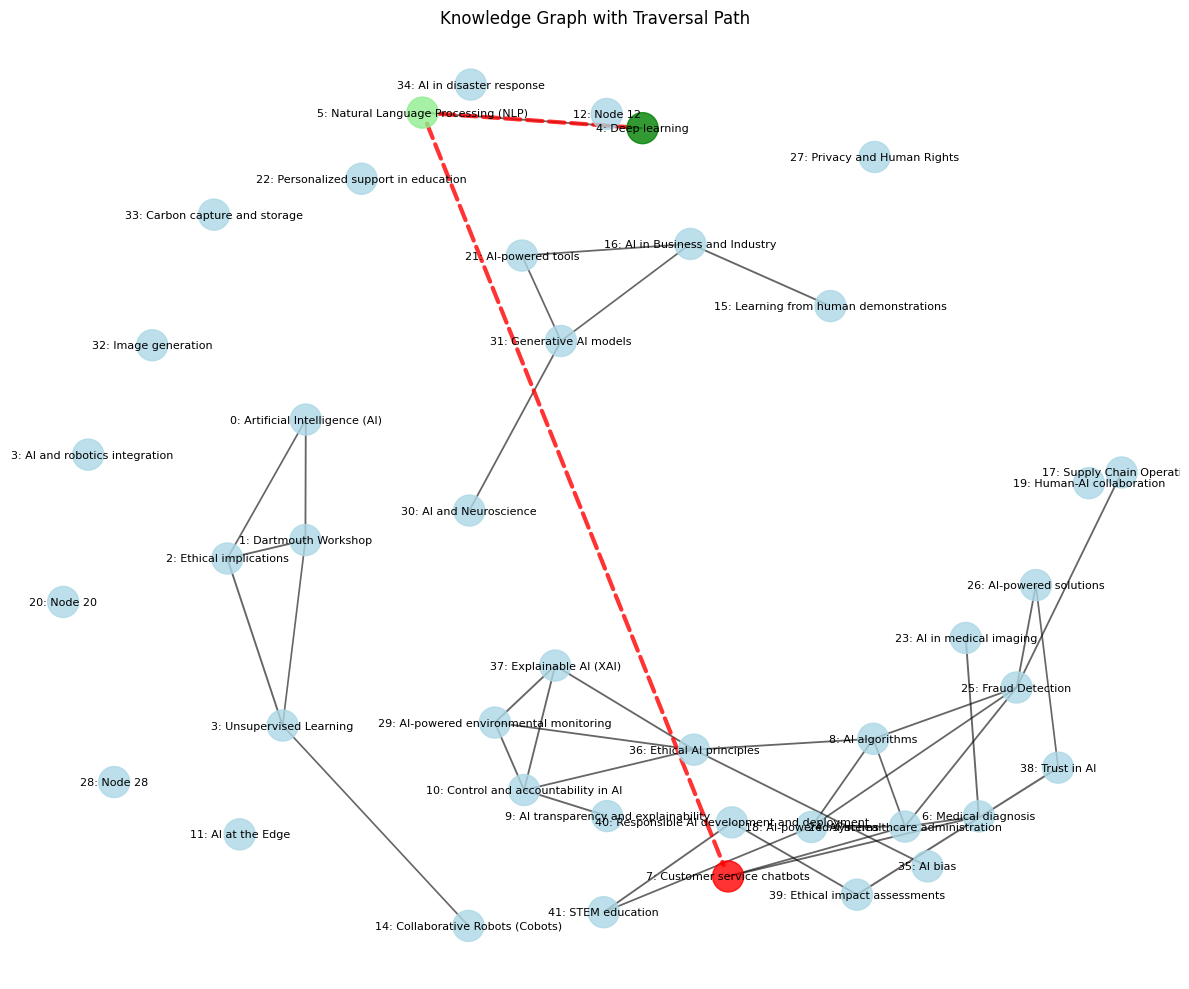


=== ANSWER ===
The context does not explicitly mention transformers or their applications in natural language processing (NLP). However, transformers are widely used in NLP for tasks such as machine translation, text summarization, sentiment analysis, and chatbots, which are mentioned in the context as general NLP applications. If you need more specific information about transformers, it is not provided in the context.
Extracting text from data/AI_Information.pdf...
Created 42 text chunks
Building knowledge graph...
Creating embeddings for chunks...
Adding nodes to the graph...
Extracting concepts for chunk 1/42...
Adding nodes to the graph...
Extracting concepts for chunk 1/42...
Extracting concepts for chunk 2/42...
Extracting concepts for chunk 2/42...
Extracting concepts for chunk 3/42...
Extracting concepts for chunk 3/42...
Extracting concepts for chunk 4/42...
Extracting concepts for chunk 4/42...
Extracting concepts for chunk 5/42...
Extracting concepts for chunk 5/42...
Extra

In [15]:
# Path to the PDF document containing AI information
pdf_path = "data/AI_Information.pdf"

# Define an AI-related query for testing Graph RAG
query = "What are the key applications of transformers in natural language processing?"

# Execute the Graph RAG pipeline to process the document and answer the query
results = graph_rag_pipeline(pdf_path, query)

# Print the response generated from the Graph RAG system
print("\n=== ANSWER ===")
print(results["response"])

# Define a test query and reference answer for formal evaluation
test_queries = [
    "How do transformers handle sequential data compared to RNNs?"
]

# Reference answer for evaluation purposes
reference_answers = [
    "Transformers handle sequential data differently from RNNs by using self-attention mechanisms instead of recurrent connections. This allows transformers to process all tokens in parallel rather than sequentially, capturing long-range dependencies more efficiently and enabling better parallelization during training. Unlike RNNs, transformers don't suffer from vanishing gradient problems with long sequences."
]

# Run formal evaluation of the Graph RAG system with the test query
evaluation = evaluate_graph_rag(pdf_path, test_queries, reference_answers)

# Print evaluation summary statistics
print("\n=== EVALUATION SUMMARY ===")
print(f"Graph nodes: {evaluation['graph_stats']['nodes']}")
print(f"Graph edges: {evaluation['graph_stats']['edges']}")
for i, result in enumerate(evaluation['results']):
    print(f"\nQuery {i+1}: {result['query']}")
    print(f"Path length: {result['traversal_path_length']}")
    print(f"Chunks used: {result['relevant_chunks_count']}")